In [33]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from evolutionary.nsga import NSGA
import requests

In [41]:
def get_close(symbol, name):
    # get ohlc data from kraken api
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval=1'
    response = requests.get(url)
    data = response.json()
    ohlc_data = data['result'][name]
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'wavg price', 'count']
    # create df
    df = pd.DataFrame(ohlc_data, columns=columns)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    # we only take close data
    df.drop(columns=['volume', 'wavg price', 'count', 'open', 'high', 'low'], inplace=True)
    df['close'] = df['close'].apply(pd.to_numeric, errors='coerce')
    df.set_index('timestamp',inplace=True)
    return df

# key is symbol, value is the name used by kraken
cryptos = {"LINKUSD":"LINKUSD" , "MATICUSD":"MATICUSD", "BTCUSD":"XXBTZUSD", "ETHUSD":"XETHZUSD"}

data_frames = {crypto:get_close(crypto, cryptos[crypto]) for crypto in cryptos}

# add normalised closed prices
for coin in data_frames: 
    data_frames[coin]['nclose'] = data_frames[coin]['close'] / data_frames[coin]['close'].iloc[0] 

# # Create a SQLite database connection
# db_conn = sqlite3.connect("PairsTradingData.db")

# # Instantiate the OHLCV class with the database connection
# ohlc_reader = util.OHLCV(db_conn)

# # Call the load method with the required parameters
# c
# exchanges = ["binance" for _ in range(len(cryptos))]
# since_date = "2024-01-01 00:01:00"

# data_frames = ohlc_reader.load(cryptos, exchanges, since_date)

In [24]:
long = ['BTCUSD']
short = ['LINKUSD', 'MATICUSD', 'ETHUSD']

def optimise(functions, population=None, num_generations=10):
    nsga = NSGA(functions, chromosome_size=len(long)+len(short))
    if population is None: population = nsga.generate_population()
    print("Generation 0")
    for i in range(num_generations):
        population = nsga.evolve(population)
        print("Generation ", i+1)
        print("Average Norm: ", nsga.avg_objective(population, 0))
        print("Average NZC: ",
              nsga.avg_objective(population, 1))
        print(population)
    _, optimal = nsga.nd_sort(population)
    best = np.array([population[i] for i in optimal[0]]) # finds pareto optimal front in final population
    return best

# Chromosome layout for NSGA: weights for long cryptos followed by weights for short cryptos

def get_spread(weights):
    df = pd.DataFrame()
    df['spread'] = weights[0] * data_frames[long[0]]['nclose']
    for i in range(1, len(long)):
        df['spread'] = df['spread'] + (weights[i] * data_frames[long[i]]['nclose'])
    for i in range(len(short)):
        df['spread'] = df['spread'] + (-weights[i+len(long)] * data_frames[short[i]]['nclose'])
    return df['spread']

# Objective functions

def nzc(weights):
    # counts how many sign changes in the spread (number of zeros crossed)
    return np.where(np.diff(np.signbit(get_spread(weights))))[0].size

def std(weights):
    return np.std(get_spread(weights))

def norm(weights):
    return np.linalg.norm(get_spread(weights))

def gap(weights):
    spread = get_spread(weights)
    return abs(spread.iloc[-1])

functions = [lambda w : norm(w), lambda w : -nzc(w)]

# frontier = optimise(functions, num_generations=40)
# print(frontier)



ADF test statistic: -2.501035759672484
ADF p value: 0.11522251660215899
Number of Zeroes Crossed: 42
Coefficient of variation: 6.3546692800130975
Norm: 0.026715980377077102


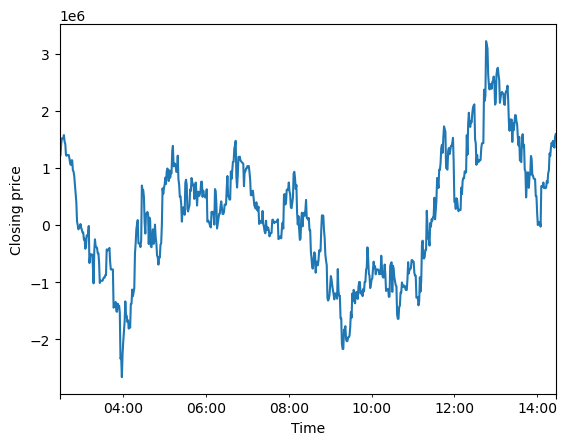

In [42]:
unnormalised_spread = pd.DataFrame(index=data_frames['BTCUSD'].index)

# Put weights here to plot graph of spread
normalised_weights = [0.34452418, 0.1991546,  0.07462569, 0.06963113]

def stats():
    spread = get_spread(normalised_weights)
    adf = adfuller(spread)
    print("ADF test statistic:", adf[0])
    print("ADF p value:", adf[1])
    print("Number of Zeroes Crossed:", nzc(normalised_weights))
    print("Coefficient of variation:", np.std(spread)/np.mean(spread))
    print("Norm:", norm(normalised_weights))

unnormalised_weights = []
unnormalised_spread['close'] = 0.0

for i in range(len(normalised_weights)):
    weight = normalised_weights[i]
    for j in range(len(normalised_weights)):
        if j != i:
            if j >= len(long):
                weight *= data_frames[short[j-len(long)]]['close'].iloc[0]
            else:
                weight *= data_frames[long[j]]['close'].iloc[0]
    if i < len(long):
        unnormalised_spread['close'] = unnormalised_spread['close'] + weight * data_frames[long[i]]['close']
        unnormalised_weights.append(weight)
    else: 
        unnormalised_spread['close'] = unnormalised_spread['close'] - weight * data_frames[short[i-len(long)]]['close']
        unnormalised_weights.append(-weight)

unnormalised_spread.plot(y='close', xlabel='Time', ylabel='Closing price', fontsize=10, legend=False, subplots=True)
stats()